In [1]:
# https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
# https://github.com/gebob19/introduction_to_normalizing_flows/blob/master/normalizing_flows.ipynb

In [2]:
import jax.numpy as np
from jax import random

import scipy.stats

import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();
plt.rcParams.update({'font.size':16})


<Figure size 640x480 with 0 Axes>

In [30]:
from tqdm.notebook import trange, tqdm 

In [3]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu # neural network layers

In [20]:
from jax.example_libraries import optimizers
from jax import jit, grad, value_and_grad
import numpy as onp

In [43]:
import jax.numpy as jnp

(-2.0, 2.0)

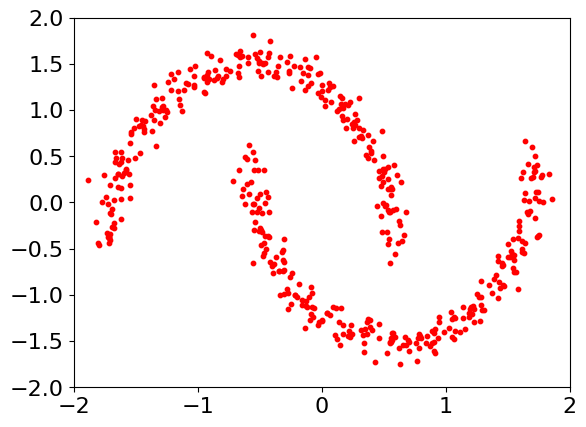

In [5]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# n_samples = 2000
n_samples = 500
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [6]:
rng = random.PRNGKey(0)

In [7]:
def sample_n01(N):
    D = 2
    return random.normal(rng, (N, D))

def log_prob_n01(x):
    return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

In [8]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
    d = x.shape[-1]//2
    x1, x2 = x[:, :d], x[:, d:]
    if flip:
        x2, x1 = x1, x2
    shift, log_scale = shift_and_log_scale_fn(net_params, x1)
    y2 = x2*np.exp(log_scale) + shift
    if flip:
        x1, y2 = y2, x1
    y = np.concatenate([x1, y2], axis=-1)
    return y

In [9]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
    d = y.shape[-1]//2
    y1, y2 = y[:, :d], y[:, d:]
    if flip:
        y1, y2 = y2, y1
    shift, log_scale = shift_and_log_scale_fn(net_params, y1)
    x2 = (y2-shift)*np.exp(-log_scale)
    if flip:
        y1, x2 = x2, y1
    x = np.concatenate([y1, x2], axis=-1)
    return x, log_scale

In [10]:
def init_nvp():
    D = 2
    net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
    in_shape = (-1, D//2)
    out_shape, net_params = net_init(rng, in_shape)
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        return np.split(s, 2, axis=1)
    return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
    x = base_sample_fn(N)
    return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
    x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
    ildj = -np.sum(log_scale, axis=-1)
    return base_log_prob_fn(x) + ildj

In [11]:
def init_nvp_chain(n=2):
    flip = False
    ps, configs = [], []
    for i in range(n):
        p, f = init_nvp()
        ps.append(p), configs.append((f, flip))
        flip = not flip
    return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
    x = base_sample_fn(N)
    for p, config in zip(ps, configs):
        shift_log_scale_fn, flip = config
        x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    return x

def make_log_prob_fn(p, log_prob_fn, config):
    shift_log_scale_fn, flip = config
    return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
    log_prob_fn = base_log_prob_fn
    for p, config in zip(ps, configs):
        log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
    return log_prob_fn(y)

In [29]:

ps, cs = init_nvp_chain(4)

def loss(params, batch):
    return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    # g = grad(loss)(params, batch)
    l, g = value_and_grad(loss)(params, batch)
    return opt_update(i, g, opt_state), l



In [144]:
%%time
iters = int(1e5)
# iters = int(1e4)
every = 100
# https://stackoverflow.com/questions/37506645/can-i-add-message-to-the-tqdm-progressbar
loop_obj = tqdm(np.arange(iters))

data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)

# for i in trange(100):
for i in loop_obj:
    opt_state, loss_value = step(i, opt_state, next(data_generator))
    if i % every == 0:
        loop_obj.set_description(f"Epoch: {i}")  # Adds text before progessbar
        loop_obj.set_postfix_str(f"Loss: {loss_value:,.3e}")  # Adds text after progressbar
ps = get_params(opt_state)


  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 21min 11s, sys: 4min 14s, total: 25min 26s
Wall time: 9min 19s


In [145]:
# %%time
# iters = int(1e4)
# data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
# opt_state = opt_init(ps)
# for i in range(iters):
#     opt_state = step(i, opt_state, next(data_generator))
# ps = get_params(opt_state)

In [146]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)


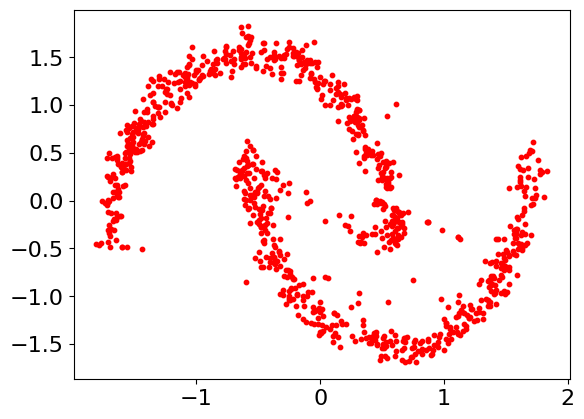

In [147]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
# xlim, ylim = [-3, 3], [-3, 3]
# plt.xlim(xlim)
# plt.ylim(ylim)

In [148]:
# make inverse function i.e. go from data-space to base-space

In [149]:
sample_n01(1)

Array([[-0.78476596,  0.85644484]], dtype=float32)

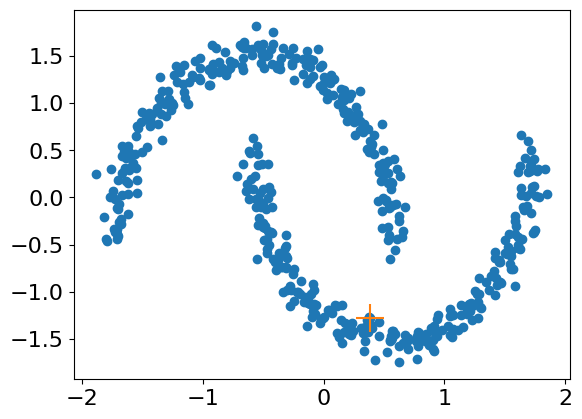

In [150]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[0,0], X[0,1], s=400, marker='+')

In [151]:
X_ = jnp.array([X[0]])

In [152]:
X_

Array([[ 0.38577512, -1.2721168 ]], dtype=float32)

In [153]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    values.append(x)

In [154]:
values[0]

Array([[ 0.2766953 , -0.19133599],
       [-1.4241    ,  0.23117462],
       [-2.1808548 ,  0.6733904 ],
       ...,
       [ 0.3556091 ,  0.8058732 ],
       [ 0.5333688 , -1.9450767 ],
       [ 0.9965214 ,  1.1420271 ]], dtype=float32)

In [155]:
len(values)

5

In [156]:
values[0][-1]

Array([0.9965214, 1.1420271], dtype=float32)

In [157]:
values[0][0]

Array([ 0.2766953 , -0.19133599], dtype=float32)

In [158]:
values[-1][0]

Array([ 1.0955215, -1.3250568], dtype=float32)

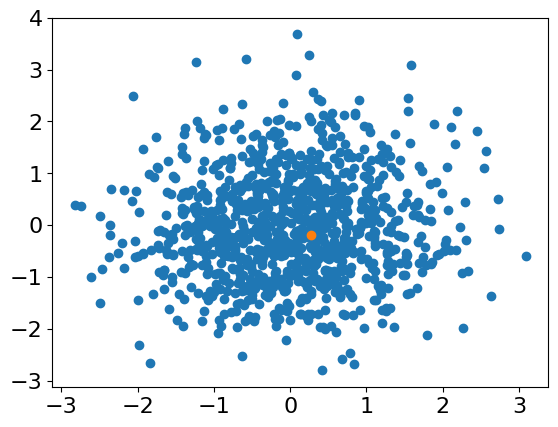

In [159]:
plt.scatter(*values[0].T)
plt.scatter(*values[0][0].T)

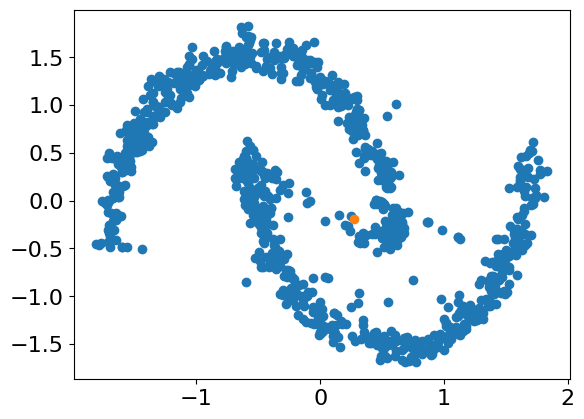

In [160]:
plt.scatter(*values[-1].T)
plt.scatter(*values[0][0].T)

In [161]:
values[0]

Array([[ 0.2766953 , -0.19133599],
       [-1.4241    ,  0.23117462],
       [-2.1808548 ,  0.6733904 ],
       ...,
       [ 0.3556091 ,  0.8058732 ],
       [ 0.5333688 , -1.9450767 ],
       [ 0.9965214 ,  1.1420271 ]], dtype=float32)

In [162]:
values[-1][0]

Array([ 1.0955215, -1.3250568], dtype=float32)

Array(-1.2841811, dtype=float32)

In [188]:
# does random sampling whilst keep x1 fixed work?

n_samples = 1000
x = sample_n01(n_samples)
x = onp.array(x)
fixed_value = x[0,1]
x[:,1] = fixed_value
# x[:,1] = 0.08701971 + onp.random.normal(0, 0.1, n_samples)
x = jnp.array(x)

In [189]:
values = [x]
for p, config in zip(ps, cs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    values.append(x)

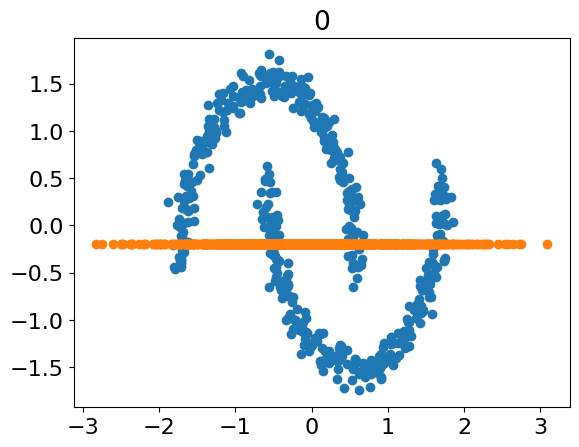

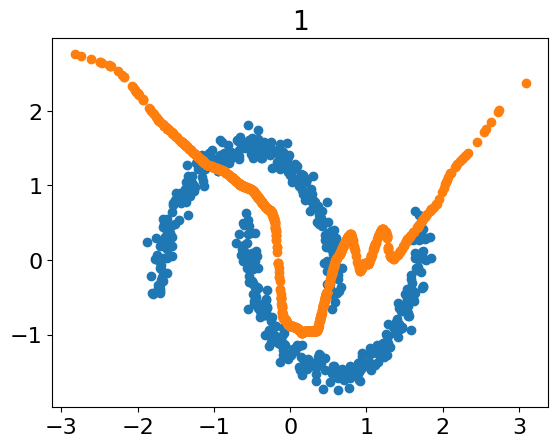

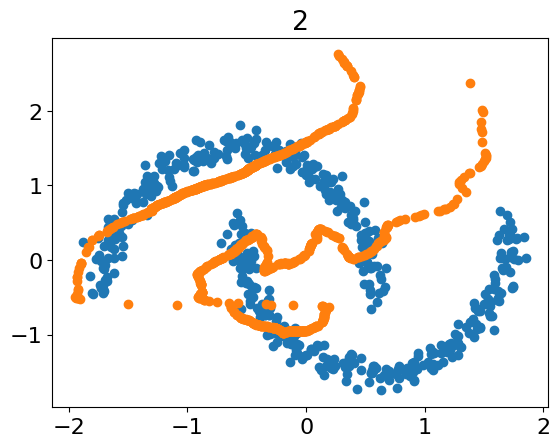

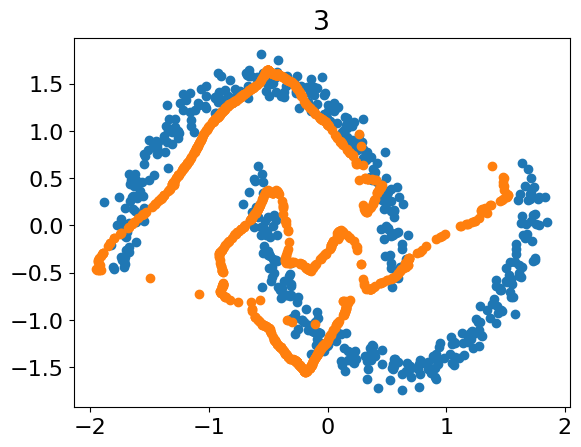

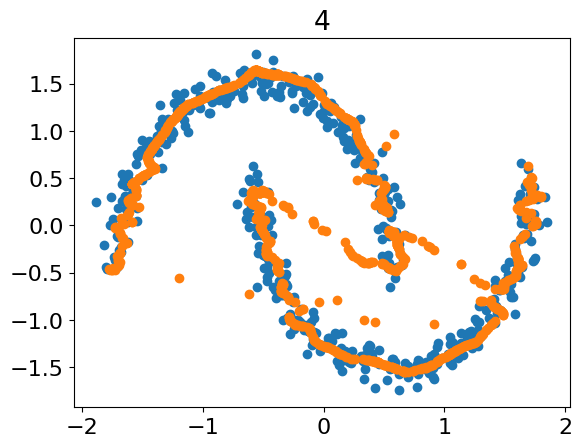

In [190]:
for i in range(len(values)):
    plt.figure()
    plt.title(i)
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(values[i][:,0], values[i][:,1])